Network Analysis of Vaccination Strategies  
Copyright (C) 2020 by The RAND Corporation  
See LICENSE.txt and README.txt for information on usage and licensing

# SIR Data Analysis Notebook

The purpose of this notebook is to analyze the results of the SIR simulation.

In [2]:
import collections, os, pickle
import powerlaw
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import random, scipy
import scipy.stats

from utils import *
import EoN

import matplotlib.pyplot as plt
import matplotlib.style as style 
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

plt.style.use('figures/theme_bw.mplstyle')
%matplotlib inline

fontsize = 16
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
fmt = mticker.FuncFormatter(g)
#pd.options.display.float_format = "{:,.3f}".format

colormap = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
## set seed
random.seed(123)
np.random.seed(123)

In [4]:
## load the contact network
#G = nx.read_gpickle("data/G_superposition.gpickle")
G = nx.read_weighted_edgelist("data/G_superposition.adjlist", nodetype=float)

In [5]:
## create a figures directory if it does not already exist
if not os.path.exists('figures'):
    os.mkdir('figures')       

## Summary statistics

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    '''taken from here: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data'''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m, h

In [7]:
## load the results
vacc_types = ['none', 'bottom', 'uniform', 'top imperfect', 'top']
I_transition = 1000

## remove the initial infecteds, before the vaccinate is applied
total_infecteds = np.load('data/SIR/total_infecteds.npy') - I_transition 
peak_infecteds = np.load('data/SIR/peak_infecteds.npy')

In [8]:
df = pd.DataFrame()

df['vacc type'] = vacc_types

df['total infected'] = [mean_confidence_interval(total_infecteds[i])[0] for i in range(len(vacc_types))]
df['total infected (+/- CI)'] = [mean_confidence_interval(total_infecteds[i])[1] for i in range(len(vacc_types))]

df['total infected (fraction)'] = [mean_confidence_interval(total_infecteds[i]/G.number_of_nodes())[0] for i in range(len(vacc_types))]
df['total infected (fraction, +/- CI)'] = [mean_confidence_interval(total_infecteds[i]/G.number_of_nodes())[1] for i in range(len(vacc_types))]

df['peak infected'] = [mean_confidence_interval(peak_infecteds[i])[0] for i in range(len(vacc_types))]
df['peak infected (+/- CI)'] = [mean_confidence_interval(peak_infecteds[i])[1] for i in range(len(vacc_types))]

df['peak infected (fraction)'] = [mean_confidence_interval(peak_infecteds[i]/G.number_of_nodes())[0] for i in range(len(vacc_types))]
df['peak infected (fraction, +/- CI)'] = [mean_confidence_interval(peak_infecteds[i]/G.number_of_nodes())[1] for i in range(len(vacc_types))]

df.sort_values(by='total infected')

,vacc type,total infected,total infected (+/- CI),total infected (fraction),"total infected (fraction, +/- CI)",peak infected,peak infected (+/- CI),peak infected (fraction),"peak infected (fraction, +/- CI)"
4,top,1691.37,290.537086,0.006155,0.001057,1033.37,5.537571,0.003761,0.000020
3,top imperfect,7296.56,181.788826,0.026554,0.000662,1534.53,26.504096,0.005585,0.000096
2,uniform,27213.45,77.890396,0.099038,0.000283,7297.59,130.734370,0.026558,0.000476
1,bottom,40626.63,69.247989,0.147852,0.000252,12755.01,129.018655,0.046419,0.000470
0,none,41153.51,77.437712,0.149769,0.000282,12880.96,146.906764,0.046878,0.000535


## Trace Plots

In [8]:
def splice_results_2(result1, result2, I_transition, t_transition):
    '''
    Splice together the results of simulation 1 and 2. I couldn't figure out how to
    save the full Simulation_Investigation object, so now results1 and 2 are simply 
    tuples.    
    '''
    t1 = result1[0]
    S1 = result1[1]['S']
    I1 = result1[1]['I']
    R1 = result1[1]['R']
    
    t2 = result2[0]
    S2 = result2[1]['S']
    I2 = result2[1]['I']
    R2 = result2[1]['R']
    
    t = np.concatenate((t1[0:I_transition], t_transition + t2[1:]))
    S = np.concatenate((S1[0:I_transition], S2[1:]))
    I = np.concatenate((I1[0:I_transition], I2[1:]))    
    R = np.concatenate((R1[0:I_transition], R2[1:]))
    
    return t, S, I, R

Make a plot comparing the strategies over time. Just look at one single run for each strategy (do not average over the 100 runs):

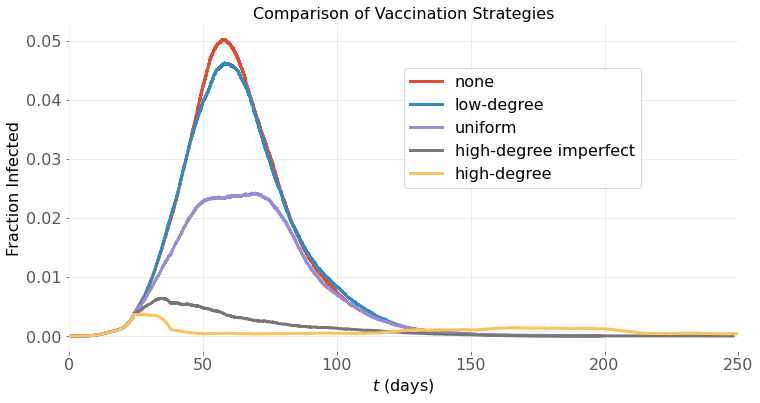

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
#ax.grid(False)

labels = ['none', 'low-degree', 'uniform', 'high-degree imperfect', 'high-degree']

for j in range(len(vacc_types)):
    vacc_type = vacc_types[j]
    i = 0
    name = 'vacc_' + vacc_type + '_iteration_' + str(i) + '.txt' 

    with open('data/SIR/result1_summary_' + name, 'rb') as file:
        result1 = pickle.load(file)
    with open('data/SIR/result2_summary_' + name, 'rb') as file:
        result2 = pickle.load(file)
        
    t_transition = result1[0][I_transition-1]
        
    t, S, I, R = splice_results_2(result1, result2, I_transition, t_transition)
    
    ax.plot(t, I/G.number_of_nodes(), lw=3, label=labels[j])
    #ax.axvline(x=0+t_transition, color='k', alpha=0.6)

ax.set_xlabel('$t$ (days)')
ax.set_xlim([0, 250])
ax.set_ylabel('Fraction Infected')
ax.legend(loc=(0.5, 0.5))
ax.set_title('Comparison of Vaccination Strategies')
plt.savefig('figures/SIR_vacc_type_comparison.png', bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

Zoom in around the vaccination time

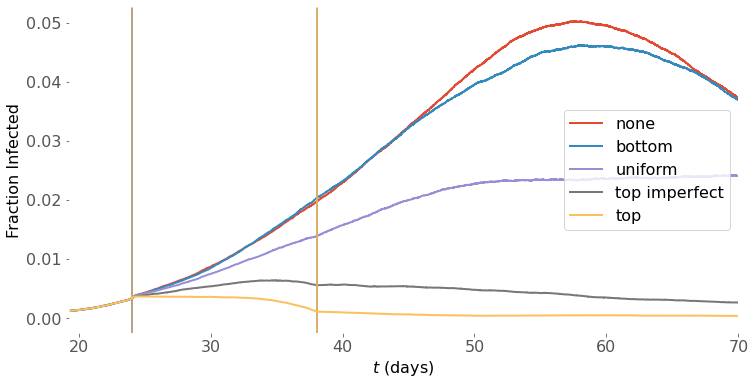

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
ax.grid(False)

for j in range(len(vacc_types)):
    vacc_type = vacc_types[j]
    i = 0
    name = 'vacc_' + vacc_type + '_iteration_' + str(i) + '.txt' 

    with open('data/SIR/result1_summary_' + name, 'rb') as file:
        result1 = pickle.load(file)
    with open('data/SIR/result2_summary_' + name, 'rb') as file:
        result2 = pickle.load(file)
        
    t_transition = result1[0][I_transition-1]
        
    t, S, I, R = splice_results_2(result1, result2, I_transition, t_transition)
    
    ax.plot(t, I/G.number_of_nodes(), lw=2, label=vacc_type)
    ax.axvline(x=0+t_transition, color=colormap[j], alpha=0.5)
    ax.axvline(x=14+t_transition, color=colormap[j], alpha=1)    
    
ax.set_xlabel('$t$ (days)')
ax.set_xlim([0.8*t_transition, 70])
ax.set_ylabel('Fraction Infected')
ax.legend(loc='right')
plt.show()

Now look at the tail in more detail:

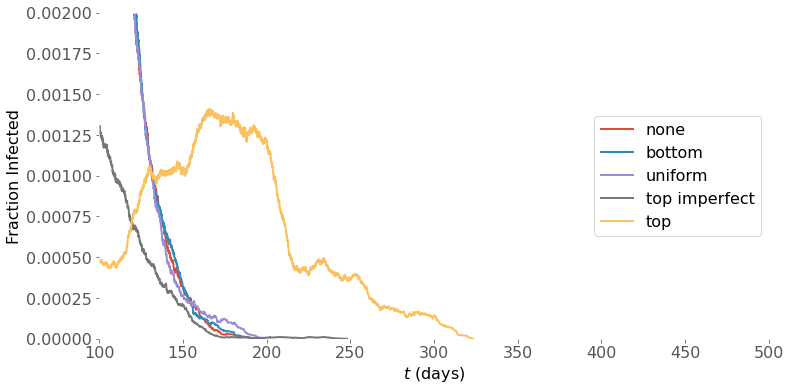

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
ax.grid(False)

for j in range(len(vacc_types)):
    vacc_type = vacc_types[j]
    i = 0
    name = 'vacc_' + vacc_type + '_iteration_' + str(i) + '.txt' 

    with open('data/SIR/result1_summary_' + name, 'rb') as file:
        result1 = pickle.load(file)
    with open('data/SIR/result2_summary_' + name, 'rb') as file:
        result2 = pickle.load(file)
        
    t_transition = result1[0][I_transition-1]
        
    t, S, I, R = splice_results_2(result1, result2, I_transition, t_transition)
    
    ax.plot(t, I/G.number_of_nodes(), lw=2, label=vacc_type)
    ax.axvline(x=0+t_transition, color=colormap[j], alpha=0.5)
    ax.axvline(x=14+t_transition, color=colormap[j], alpha=1)    
    
ax.set_xlabel('$t$ (days)')
ax.set_xlim([100, 500])
ax.set_ylim([0, 0.002])
ax.set_ylabel('Fraction Infected')
ax.legend(loc='right')
plt.show()

## Degree Distribution of Infected Nodes

Plot the degree distribution of the infected nodes (only counting those infected after vaccination applied). I am combining the results of the 100 experiments in these plots.

In [12]:
def degree_dist_calculator_pool(iterations, vacc_type):
    '''
    x
    '''
    degree_sequence = np.empty(0)
    for i in range(iterations):
        nodes = np.load('data/SIR/recovereds_after_vaccination_vacc_' \
                                               + vacc_type + '_iteration_' + str(i) + '.txt', allow_pickle=True)
        degree_sequence = np.concatenate((degree_sequence, \
                                          np.asarray(sorted([d for n, d in G.degree(nodes)], reverse=False))))
    
    degree_sequence = np.sort(degree_sequence)
    degree_counter = collections.Counter(np.sort(degree_sequence))
    return np.asarray(list(degree_counter.keys())), np.asarray(list(degree_counter.values())), degree_sequence


def CDF(G, nodes=None):
    '''
    x
    '''
    degree_sequence = np.asarray(sorted([d for n, d in G.degree(nodes)], reverse=False))
    rank = {i+1:degree_sequence[-(i+1)] for i in range(len(degree_sequence))}
    Pk = np.asarray(list(rank.keys()))/len(degree_sequence)
    return degree_sequence, Pk


def CDF_pool(iterations, vacc_type):
    '''
    x
    '''
    degree_sequence = np.empty(0)
    for i in range(iterations):
        nodes = np.load('data/SIR/recovereds_after_vaccination_vacc_' \
                                               + vacc_type + '_iteration_' + str(i) + '.txt', allow_pickle=True)
        degree_sequence = np.concatenate((degree_sequence, \
                                          np.asarray(sorted([d for n, d in G.degree(nodes)], reverse=False))))
    degree_sequence = np.sort(degree_sequence) 
    rank = {i+1:degree_sequence[-(i+1)] for i in range(len(degree_sequence))}
    Pk = np.asarray(list(rank.keys()))/len(degree_sequence)
    return degree_sequence, Pk

In [13]:
iterations = 100

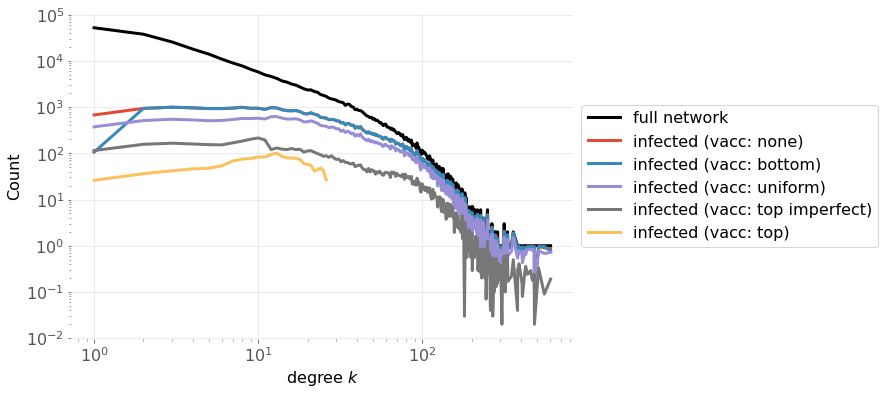

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
lw = 3

## small degree, linear scale
degree_dist = degree_dist_calculator(G)
ax.loglog(degree_dist[0], degree_dist[1], linewidth=lw, label='full network', color='k')

for j in range(5):
    degrees, counts, _ = degree_dist_calculator_pool(iterations, vacc_types[j])
    ax.loglog(degrees, counts/iterations, linewidth=lw, label='infected (vacc: %s)' % vacc_types[j])

## plot legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel("Count")
ax.set_xlabel(r"degree $k$")
plt.savefig('figures/SIR_degree_dist.pdf', bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

Next plot the CDF $P_k$, the fraction of nodes with degree $k$ or greater.

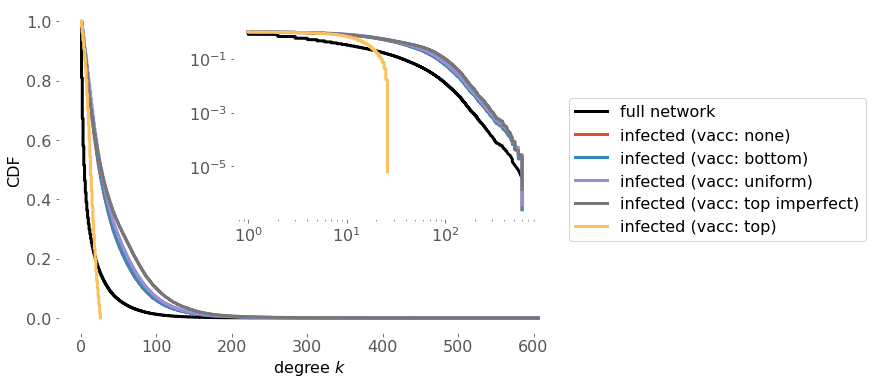

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
lw = 3

## main plot
degree_sequence, Pk = CDF(G)
ax.plot(degree_sequence, -np.sort(-Pk), label='full network', lw=lw, color='k')

for j in range(5):
    degree_sequence, Pk = CDF_pool(iterations, vacc_types[j])
    ax.plot(degree_sequence, -np.sort(-Pk), label='infected (vacc: %s)' % vacc_types[j], lw=lw)
ax.set_xlabel(r'degree $k$')
ax.set_ylabel('CDF')

## main plot legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## inset
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.35,0.35,0.6,0.6])
ax2.set_axes_locator(ip)

degree_sequence, Pk = CDF(G)
ax2.plot(degree_sequence, -np.sort(-Pk), label='full network', lw=lw, color='k')

for j in range(5):
    vacc_type = vacc_types[j]
    degree_sequence, Pk = CDF_pool(iterations, vacc_type)
    ax2.plot(degree_sequence, -np.sort(-Pk), label='infected (vacc: %s)' % vacc_types[j], lw=lw)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax.grid(False)
ax2.grid(False)
plt.savefig('figures/SIR_CDF.pdf', bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

In [16]:
def bar_plot_maker(degree_sequence, intervals):
    counts = []    
    for i in range(len(intervals)-1):
        counts.append(np.sum((intervals[i] <= degree_sequence) & (degree_sequence < intervals[i+1])))
    return np.asarray(counts)

In [17]:
intervals = [1, 3, 5, 10, 50, np.inf]
bar_plot_maker(degree_sequence, intervals)

array([  6232,   8804,  32133, 113337,      0])

In [18]:
np.sum(bar_plot_maker(degree_sequence, intervals))

160506

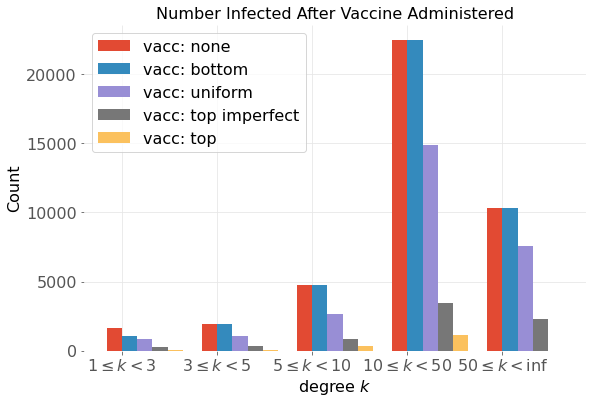

In [24]:
N = len(intervals) - 1
ind = np.arange(N)  # the x locations for the groups
width = 0.16       # the width of the bars

fig, ax = plt.subplots(figsize=(9,6))

labels = [str(intervals[i]) + r'$\leq k < $' + str(intervals[i+1]) for i in range(len(intervals)-1)]
labels = [r'{}'.format(label) for label in labels]
df = pd.DataFrame(columns=labels)

for j in range(len(vacc_types)):
    _, _, degree_sequence = degree_dist_calculator_pool(iterations, vacc_types[j])
    counts = bar_plot_maker(degree_sequence, intervals)/iterations
    ax.bar(ind + width*j, counts, width=width, label='vacc: %s' % vacc_types[j])
    df.loc[vacc_types[j]] = counts
    
plt.xticks(ind+width/2, labels)
ax.legend(loc='best')
ax.set_xlabel(r'degree $k$')
ax.set_ylabel('Count')
ax.set_title('Number Infected After Vaccine Administered')
ax.legend()
plt.savefig('figures/SIR_barplot.png', bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

In [25]:
df

,1$\leq k < $3,3$\leq k < $5,5$\leq k < $10,10$\leq k < $50,50$\leq k < $inf
none,1613.76,1953.91,4745.29,22426.35,10327.89
bottom,1041.48,1962.63,4741.81,22444.78,10349.62
uniform,885.41,1073.86,2694.49,14885.72,7587.66
top imperfect,271.75,324.25,860.18,3445.45,2308.62
top,62.32,88.04,321.33,1133.37,0.00
